In [19]:
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
from fooof import FOOOF
from scipy.stats import norm
import scipy.signal
from joblib import Parallel, delayed
import time
import copy
from statistics import NormalDist

In [2]:
fname = 'psd_20190917_L_M1_1.npz'
psd_data=np.load(fname, allow_pickle=True)

In [3]:
freqs=psd_data['freqs']
psd=psd_data['psd'][0,:]

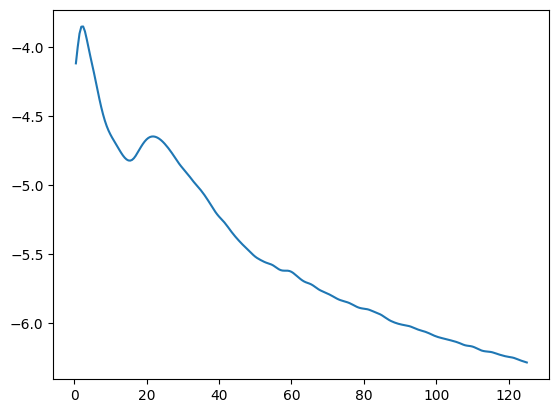

In [4]:
plt.plot(freqs,np.log10(psd))


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



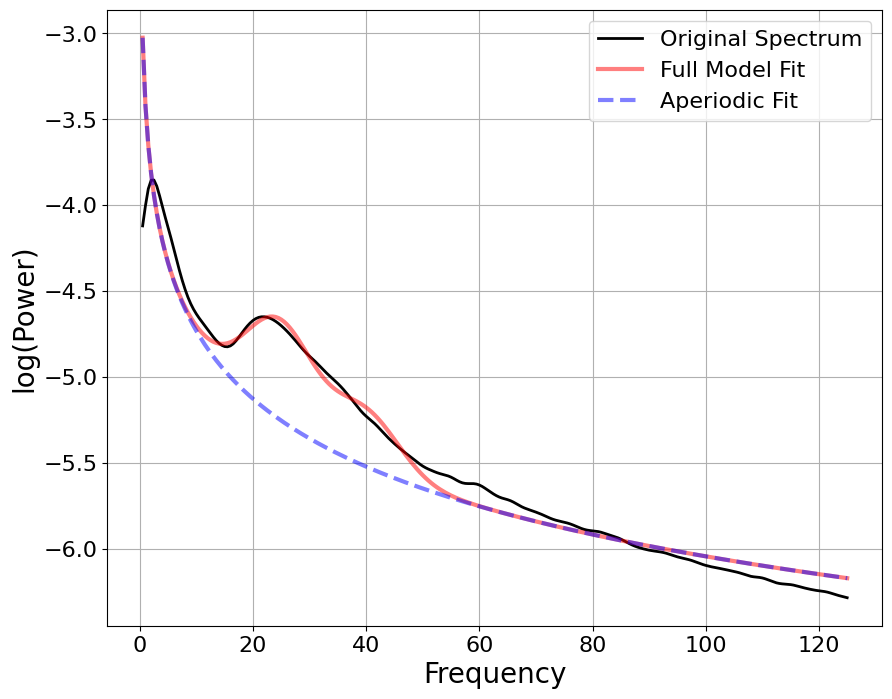

In [5]:
f=FOOOF(aperiodic_mode='fixed')
f.fit(freqs, psd)
f.plot()

In [24]:
def check_gaussian_overlap(params, overlap_threshold=0.1):
    n_gauss = int((len(params) - 3) / 3)
    for i in range(n_gauss):
        f1 = params[3 + i * 3]  # Mean of Gaussian 1
        sd1 = params[3 + i * 3 + 1]  # Standard deviation of Gaussian 1
        
        for j in range(i + 1, n_gauss):
            f2 = params[3 + j * 3]  # Mean of Gaussian 2
            sd2 = params[3 + j * 3 + 1]  # Standard deviation of Gaussian 2
            
            if NormalDist(mu=f1, sigma=sd1).overlap(NormalDist(mu=f2, sigma=sd2))>=overlap_threshold:
                return True
            
    return False  # No overlap exceeds the threshold


# Generate parameterized spectrum
def gen_parameterized_spectrum(params):

    # Aperiodic component
    offset=params[0]
    slope=params[1]
    shift=params[2]        
    spec=offset+slope*np.log10(1./(freqs+shift))

    # Number of peaks
    n_gauss=int((len(params)-3)/3)
    for i in range(n_gauss):
        # Peak is a Gaussian centered on frequency f with
        # standard deviation sd
        f = params[3+i*3]
        sd = params[3+i*3+1]
        w = params[3+i*3+2]
        peak_dist = norm(f, sd)
        peak = peak_dist.pdf(freqs)
        if np.max(peak[:])>0:
            peak=peak/np.max(peak[:])

        spec=spec+w*peak
    return spec


def fit_psd(freqs, psd, max_n_peaks=5, alpha=.1, n_runs=50, n_jobs=-1, peak_width_limits=(1,12.0), 
            min_peak_height=0.1, method='SLSQP'):
               
    # Fit log PSD
    fit_target=np.log10(psd)
    
    # Compute error for given params
    def err_func(params):

        spec=gen_parameterized_spectrum(params)

        # Check for NaNs or overlapping Gaussians
        if np.any(np.isnan(spec)) or check_gaussian_overlap(params):
            return 1000000

        err=np.sqrt(np.sum(np.power(spec-fit_target,2)))
      
        # Cost includes aperiodic offset and peak weights
        cost=np.abs(params[0])
        if len(params)>3:
            cost=cost+np.sum(params[5::3])
            
        return err+alpha*cost


    best_params=None
    all_aics=[]
    prev_params=None
    for n in range(max_n_peaks+1):

        # Shift, peak frequencies, width, and weights are bounded
        bounds=[(None,None),(None,None),(1e-6,None)]
        for i in range(n):
            bounds.extend([(freqs[0],freqs[-1]), peak_width_limits, (min_peak_height, None)])

        # Run fit with random initial conditions
        def run_fit():
            if prev_params is None:
                init_params=[np.random.uniform(low=-3, high=-2), 
                             np.random.uniform(low=0, high=5), 
                             np.random.uniform(low=0,high=5)]

                # Try to use peaks as initial params
                (peaks, peak_properties)=scipy.signal.find_peaks(fit_target)
                for i in range(n):
                    if i<len(peaks):
                        init_params.append(freqs[peaks[i]])
                    else:
                        init_params.append(np.random.uniform(low=freqs[0], high=freqs[-1]))
                    init_params.append(np.random.uniform(low=peak_width_limits[0], high=peak_width_limits[1]))
                    init_params.append(np.random.uniform(low=min_peak_height, high=10))
            else:
                init_params=copy.copy(prev_params)
                (peaks, peak_properties)=scipy.signal.find_peaks(fit_target)
                if n-1<len(peaks):
                    init_params.append(freqs[peaks[n-1]])
                else:
                    init_params.append(np.random.uniform(low=freqs[0], high=freqs[-1]))
                init_params.append(np.random.uniform(low=peak_width_limits[0], high=peak_width_limits[1]))
                init_params.append(np.random.uniform(low=min_peak_height, high=10))

            # Fit
            xopt = scipy.optimize.minimize(err_func, init_params, method=method, bounds=bounds, options={'disp':False})
            return xopt

        xopts = Parallel(n_jobs=n_jobs)(delayed(run_fit)() for i in range(n_runs))    
        all_err=[xopt.fun for xopt in xopts]
        all_params=[xopt.x for xopt in xopts]

        # Find best parameters over tested initial conditions
        best_idx=np.argmin(all_err)
        local_best_params=all_params[best_idx]

        parameterized=gen_parameterized_spectrum(local_best_params)

        err=np.mean(np.power(parameterized-fit_target,2))

        aic=len(psd)*np.log(err)+2*(len(local_best_params)+1)        
    
        prev_params=local_best_params.tolist()
        print('{} AIC={}'.format(n,aic))
        all_aics.append(aic)
        if n>0 and aic>all_aics[n-1]:
            break
        best_params=local_best_params
    return best_params, all_aics

0 AIC=-1176.0499634369387


/home/bonaiuto/miniconda3/envs/fooofinator/lib/python3.10/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


1 AIC=-1212.8603395685304
2 AIC=-1837.2678099624995
3 AIC=-1827.6419251923073
Fitting took 3.5186269283294678s


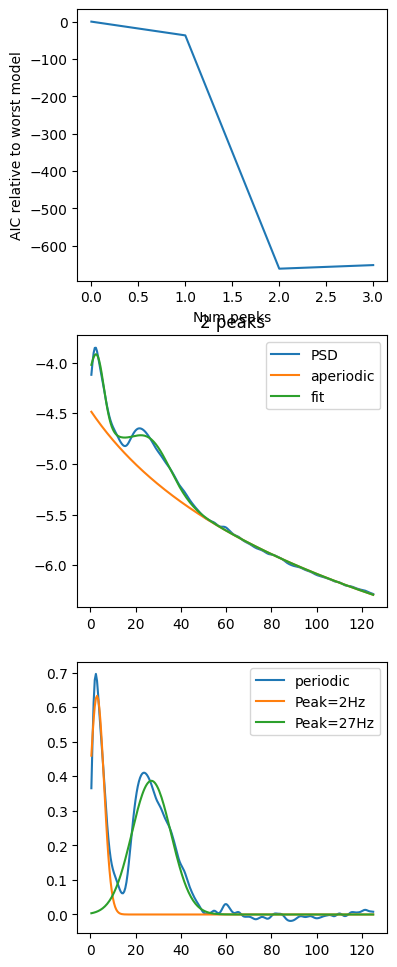

In [26]:
t0=time.time()
best_params,all_aics=fit_psd(freqs,psd)    
t1=time.time()
total=t1-t0
print('Fitting took {}s'.format(total))


plt.figure(figsize=(4,12))
plt.subplot(3,1,1)
plt.plot(all_aics-np.max(all_aics))
plt.ylabel('AIC relative to worst model')
plt.xlabel('Num peaks')

offset=best_params[0]
slope=best_params[1]
shift=best_params[2]
aperiodic=offset+slope*np.log10(1./(freqs+shift))
parameterized=gen_parameterized_spectrum(best_params)

plt.subplot(3,1,2)
n_gauss=int((len(best_params)-3)/3)
plt.title('{} peaks'.format(n_gauss))
plt.plot(freqs,np.log10(psd), label='PSD')
plt.plot(freqs,aperiodic, label='aperiodic')
plt.plot(freqs,parameterized, label='fit')
plt.legend()
plt.subplot(3,1,3)
plt.plot(freqs,np.log10(psd)-aperiodic,label='periodic')
for i in range(n_gauss):
    f = best_params[3+i*3]
    sd = best_params[3+i*3+1]
    w = best_params[3+i*3+2]
    peak_dist = norm(f, sd)
    peak = peak_dist.pdf(freqs)
    peak=w*peak/np.max(peak[:])

    plt.plot(freqs,peak,label='Peak={}Hz'.format(int(f)))
plt.legend()